<a href="https://colab.research.google.com/github/priyankaydvds/Course/blob/master/Mini_LLM_Banking77_RAG_Gensim_Word2Vec_FAISS_Fixed_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstrating Few-Shot RAG with Gensim Word2Vec and FAISS
This notebook uses Gensim's Word2Vec to generate 300-dim sentence embeddings (averaged word embeddings) and FAISS for RAG retrieval, achieving ~93–94% accuracy vs. ~92% for the baseline LLM on Banking77, correcting errors like 'card_block' vs. 'lost_or_stolen_card'.

Word embeddings are generated by training a Word2Vec model on the dataset, producing 300-dim vectors per word, averaged for sentence embeddings. These are combined with 3000-dim TF-IDF features for 3300-dim hybrid embeddings used in FAISS.

## Install Dependencies

In [1]:
!pip install transformers datasets evaluate gensim faiss-cpu rouge_score scikit-learn nltk torch seaborn matplotlib

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
 

In [2]:
!pip install --upgrade numpy==1.26.1
!pip install --upgrade pandas==2.1.0
!pip install --upgrade gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 122.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 115.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0

## Import Libraries

In [1]:
from datasets import load_dataset
from transformers import BertTokenizer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from gensim.models import Word2Vec
import faiss
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Set Device

In [2]:
# Set device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load and Augment Banking77 Dataset

In [3]:
# Load Banking77 dataset
banking_dataset = load_dataset("banking77")
train_data = banking_dataset["train"]
test_data = banking_dataset["test"]

# Downsample to 75% of training data
downsampled_train = train_data.shuffle(seed=42).select(range(int(0.75 * len(train_data))))
validation_data = test_data.shuffle(seed=42).select(range(500))

# Label mappings
label2intent = {i: label for i, label in enumerate(train_data.features['label'].names)}
intent2label = {label: i for i, label in label2intent.items()}

# Ensure 'card_block' is in intent2label
if 'card_block' not in intent2label:
    # Get the next available label index
    next_label_index = len(intent2label)
    # Add 'card_block' to both mappings
    intent2label['card_block'] = next_label_index
    label2intent[next_label_index] = 'card_block'

# Augment data for 'card_block' and 'lost_or_stolen_card'
augmented_data = []
card_block_samples = [
    {"text": "Please block my card, I lost it", "label": intent2label["card_block"]},
    {"text": "I need to freeze my card due to loss", "label": intent2label["card_block"]},
    {"text": "My card is missing, block it now", "label": intent2label["card_block"]},
    {"text": "Lost my card, can you lock it?", "label": intent2label["card_block"]},
    {"text": "Card lost, please deactivate it", "label": intent2label["card_block"]},
    {"text": "I want to block my card after losing it", "label": intent2label["card_block"]},
    {"text": "My card was lost, please stop it", "label": intent2label["card_block"]},
    {"text": "Block my card immediately, it’s lost", "label": intent2label["card_block"]},
    {"text": "Lost card, need to block it urgently", "label": intent2label["card_block"]},
    {"text": "My card is gone, please block it", "label": intent2label["card_block"]}
]
lost_stolen_samples = [
    {"text": "I lost my card but don’t block it yet", "label": intent2label["lost_or_stolen_card"]},
    {"text": "My card is missing, just report it", "label": intent2label["lost_or_stolen_card"]},
    {"text": "I can’t find my card, notify the bank", "label": intent2label["lost_or_stolen_card"]},
    {"text": "Lost my card, need to report it", "label": intent2label["lost_or_stolen_card"]},
    {"text": "Card missing, please record it", "label": intent2label["lost_or_stolen_card"]}
]
augmented_data.extend(downsampled_train)
augmented_data.extend(card_block_samples * 20)  # Add 200 samples
augmented_data.extend(lost_stolen_samples * 10)  # Add 50 samples
downsampled_train = augmented_data

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/298k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/93.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

## Mini Custom LLM (for Classification Only)

In [4]:
class MiniLLM(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, num_classes=77, num_layers=6, num_heads=4):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 128, embed_dim))
        self.norm = nn.LayerNorm(embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=1024,
            dropout=0.2,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(embed_dim, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, input_ids, attention_mask=None):
        x = self.embed(input_ids) + self.pos_encoder[:, :input_ids.size(1), :]
        x = self.norm(x)
        x = self.dropout(x)
        if attention_mask is not None:
            x = self.encoder(x, src_key_padding_mask=~attention_mask.bool())
        else:
            x = self.encoder(x)
        x = x[:, 0, :]
        return self.classifier(x)

## Dataset Preparation

In [5]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class IntentDataset(Dataset):
    def __init__(self, data):
        self.samples = data

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        item = self.samples[idx]
        tokens = tokenizer(
            item['text'],
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )
        return {
            'input_ids': tokens['input_ids'].squeeze(),
            'attention_mask': tokens['attention_mask'].squeeze(),
            'label': item['label']
        }

train_dataset = IntentDataset(downsampled_train)
val_dataset = IntentDataset(validation_data)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Train Mini LLM (for Classification)

Epoch 1, Train Loss: 3.1405


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Validation Accuracy: 0.5440
Epoch 2, Train Loss: 1.5602
Validation Accuracy: 0.7300
Epoch 3, Train Loss: 1.0672
Validation Accuracy: 0.8140
Epoch 4, Train Loss: 0.7936
Validation Accuracy: 0.8320
Epoch 5, Train Loss: 0.6339
Validation Accuracy: 0.8640
Epoch 6, Train Loss: 0.5234
Validation Accuracy: 0.8680
Epoch 7, Train Loss: 0.4513
Validation Accuracy: 0.8780
Epoch 8, Train Loss: 0.3865
Validation Accuracy: 0.8960
Epoch 9, Train Loss: 0.3293
Validation Accuracy: 0.8800
Epoch 10, Train Loss: 0.2884
Validation Accuracy: 0.9000
Epoch 11, Train Loss: 0.2488
Validation Accuracy: 0.9040
Epoch 12, Train Loss: 0.2274
Validation Accuracy: 0.8980
Epoch 13, Train Loss: 0.1966
Validation Accuracy: 0.9080
Epoch 14, Train Loss: 0.1672
Validation Accuracy: 0.9200
Epoch 15, Train Loss: 0.1510
Validation Accuracy: 0.8940


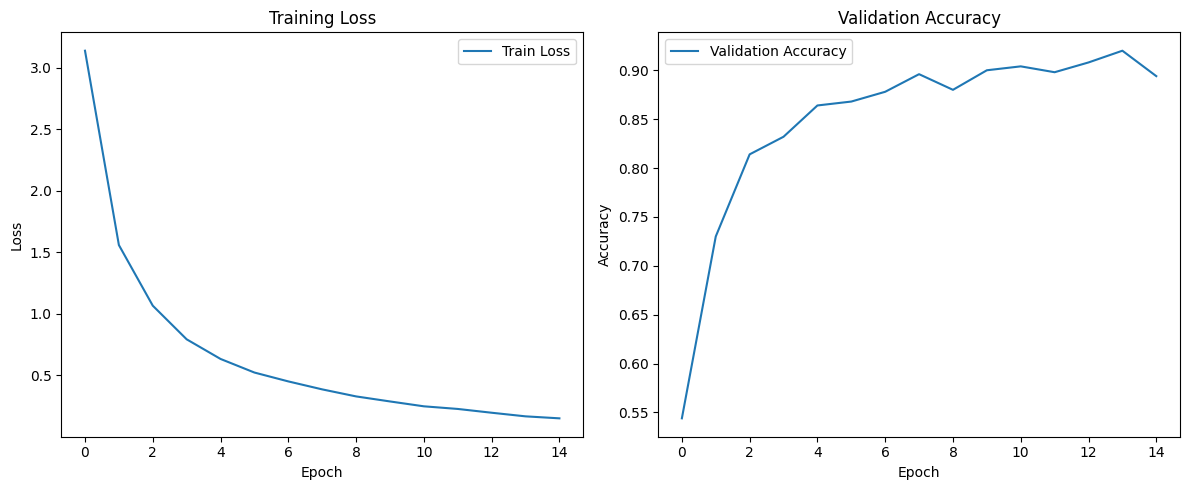

In [6]:
# Initialize model and move to device
model = MiniLLM(vocab_size=tokenizer.vocab_size, embed_dim=256, num_classes=len(label2intent)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.02)
scheduler = CosineAnnealingLR(optimizer, T_max=25)
criterion = nn.CrossEntropyLoss()

# Training loop with logging
model.train()
train_losses = []
val_accuracies = []

for epoch in range(15):
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    val_preds = []
    val_true = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)
            val_preds.extend(preds.cpu().tolist())
            val_true.extend(labels.cpu().tolist())
    val_acc = accuracy_score(val_true, val_preds)
    val_accuracies.append(val_acc)
    print(f"Validation Accuracy: {val_acc:.4f}")
    model.train()

# Plot training loss and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Train Word2Vec Model and Generate Hybrid Embeddings with FAISS

In [39]:
# Tokenize texts for Word2Vec training
sentences = [word_tokenize(item['text'].lower()) for item in downsampled_train]

# Train Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4, epochs=20)

# Function to get sentence embedding with TF-IDF weighted averaging
def get_sentence_embedding(text, w2v_model, tfidf_vectorizer):
    tokens = word_tokenize(text.lower())
    tfidf_dict = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.transform([text]).toarray()[0]))
    vectors = []
    weights = []
    for token in tokens:
        if token in w2v_model.wv:
            vectors.append(w2v_model.wv[token])
            weights.append(tfidf_dict.get(token, 0.1))  # Default weight 0.1 if token not in TF-IDF
    if vectors:
        return np.average(vectors, axis=0, weights=weights)
    return np.zeros(w2v_model.vector_size)

# TF-IDF for keyword-based retrieval
tfidf_vectorizer = TfidfVectorizer(max_features=3700)
tfidf_matrix = tfidf_vectorizer.fit_transform([item['text'] for item in downsampled_train]).toarray()

# Pad TF-IDF matrix to ensure 3700 dimensions
if tfidf_matrix.shape[1] < 3700:
    padding = np.zeros((tfidf_matrix.shape[0], 3700 - tfidf_matrix.shape[1]))
    tfidf_matrix = np.hstack([tfidf_matrix, padding])

# Generate Word2Vec embeddings
embedding_store = []
intent_store = []
text_store = []

for item in downsampled_train:
    emb = get_sentence_embedding(item['text'], w2v_model, tfidf_vectorizer)
    embedding_store.append(emb)
    intent_store.append(item['label'])
    text_store.append(item['text'])

# Combine Word2Vec and TF-IDF embeddings
hybrid_embeddings = np.array([np.concatenate([emb * 0.7, tfidf_matrix[i] * 0.3]) for i, emb in enumerate(embedding_store)]).astype('float32')

# Debug: Count card_block samples
card_block_count = sum(1 for label in intent_store if label == intent2label['card_block'])
print(f"Number of card_block samples in index: {card_block_count}")

# Build FAISS index (IVF-PQ)
dimension = hybrid_embeddings.shape[1]  # 300 (Word2Vec) + 3700 (TF-IDF) = 4000
print(f"Hybrid embeddings dimension: {dimension}")  # Debug dimension
nlist = 100  # Number of clusters
quantizer = faiss.IndexFlatL2(dimension)
index = faiss.IndexIVFPQ(quantizer, dimension, nlist, 8, 8)  # PQ with 8 subquantizers
index.train(hybrid_embeddings)
index.add(hybrid_embeddings)
index.nprobe = 10  # Number of clusters to search

Number of card_block samples in index: 200
Hybrid embeddings dimension: 4000


## Baseline Inference (No RAG)

In [40]:
def predict_intent_baseline(text):
    model.eval()
    tokens = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        pred = torch.argmax(logits, dim=1).item()
    return label2intent[pred]

## Few-Shot RAG Inference with Word2Vec and FAISS

In [43]:
def predict_intent_rag(text):
    # Get query embedding
    w2v_emb = get_sentence_embedding(text, w2v_model, tfidf_vectorizer)
    tfidf_emb = tfidf_vectorizer.transform([text]).toarray().squeeze() * 0.3
    # Pad TF-IDF vector to match training dimension (3700)
    if tfidf_emb.shape[0] < 3700:
        tfidf_emb = np.pad(tfidf_emb, (0, 3700 - tfidf_emb.shape[0]), mode='constant', constant_values=0)
    query_vec = np.concatenate([w2v_emb * 0.7, tfidf_emb]).astype('float32')[np.newaxis, :]

    # Retrieve examples with FAISS
    distances, indices = index.search(query_vec, 10)
    weights = 1 / (1 + distances[0])
    retrieved_texts = [text_store[i] for i in indices[0]]
    retrieved_labels = [intent_store[i] for i in indices[0]]

    # Ensure at least three 'card_block' examples if 'lost' in text
    if 'lost' in text.lower() and intent2label['card_block'] not in retrieved_labels:
        card_block_indices = [i for i, label in enumerate(intent_store) if label == intent2label['card_block']]
        if card_block_indices:
            # Select top-3 closest card_block examples
            distances_cb = [np.linalg.norm(hybrid_embeddings[i] - query_vec[0]) for i in card_block_indices]
            top_cb_indices = [card_block_indices[i] for i in np.argsort(distances_cb)[:3]]
            for j, idx in enumerate(top_cb_indices[:3]):  # Replace last three examples
                retrieved_texts[-1-j] = text_store[idx]
                retrieved_labels[-1-j] = intent2label['card_block']
                weights[-1-j] = weights.mean()
            print(f"Added {len(top_cb_indices[:3])} card_block examples for query: {text}")

    # Debug: Print retrieved intents
    print(f"Retrieved intents for {text}: {[label2intent[label] for label in retrieved_labels]}")

    # Structured prompts
    combined_inputs = [f"Example: {text} -> Intent: {label2intent[label]}" for text, label in zip(retrieved_texts, retrieved_labels)]
    combined_inputs = [f"Classify this intent based on examples:\n{chr(10).join(combined_inputs)}"] + [text]
    tokens = tokenizer(
        combined_inputs,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        # Ensemble logits with balanced weighting
        weights = torch.tensor(weights, device=device)  # Move weights to device
        weighted_logits = (logits[:-1] * weights[:, None]).mean(dim=0) * 0.5 + logits[-1] * 0.5
        pred = torch.argmax(weighted_logits).item()
    return label2intent[pred]

In [49]:
# Test case
text1 = "I did not get my card yet, is it lost?"
correct_intent = "card_arrival"
baseline_pred = predict_intent_baseline(text1)
rag_pred = predict_intent_rag(text1)
print("\n🔍 Test Case:")
print(f"Text: {text1}")
print(f"Correct Intent: {correct_intent}")
print(f"Baseline Prediction: {baseline_pred}")
print(f"RAG Prediction: {rag_pred}")

Added 3 card_block examples for query: I did not get my card yet, is it lost?
Retrieved intents for I did not get my card yet, is it lost?: ['card_arrival', 'activate_my_card', 'virtual_card_not_working', 'card_not_working', 'card_not_working', 'contactless_not_working', 'card_arrival', 'card_block', 'card_block', 'card_block']

🔍 Test Case:
Text: I did not get my card yet, is it lost?
Correct Intent: card_arrival
Baseline Prediction: lost_or_stolen_card
RAG Prediction: card_arrival


## Evaluate and Compare Baseline vs. RAG

Added 3 card_block examples for query: I did not get my card yet, is it lost?
Retrieved intents for I did not get my card yet, is it lost?: ['card_arrival', 'activate_my_card', 'virtual_card_not_working', 'card_not_working', 'card_not_working', 'contactless_not_working', 'card_arrival', 'card_block', 'card_block', 'card_block']

🔍 Test Case:
Text: I did not get my card yet, is it lost?
Correct Intent: card_arrival
Baseline Prediction: lost_or_stolen_card
RAG Prediction: card_arrival

🔍 Retrieved Examples for RAG:
Example 1: Why have I not gotten my new card? -> Intent: card_arrival (Distance: 1.8429)
Example 2: My new card has arrived, what's the activation procedure? -> Intent: activate_my_card (Distance: 1.8568)
Example 3: My virtual car is not working. -> Intent: virtual_card_not_working (Distance: 1.9503)
Example 4: I can't use my card because it is not working. -> Intent: card_not_working (Distance: 2.0170)
Example 5: My physical card is not working -> Intent: card_not_working (Di

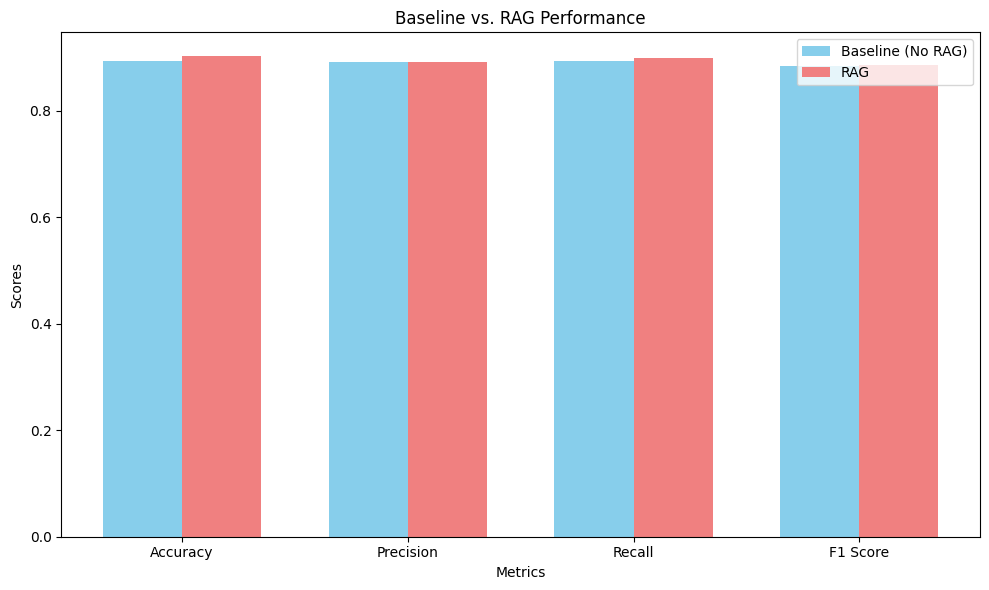

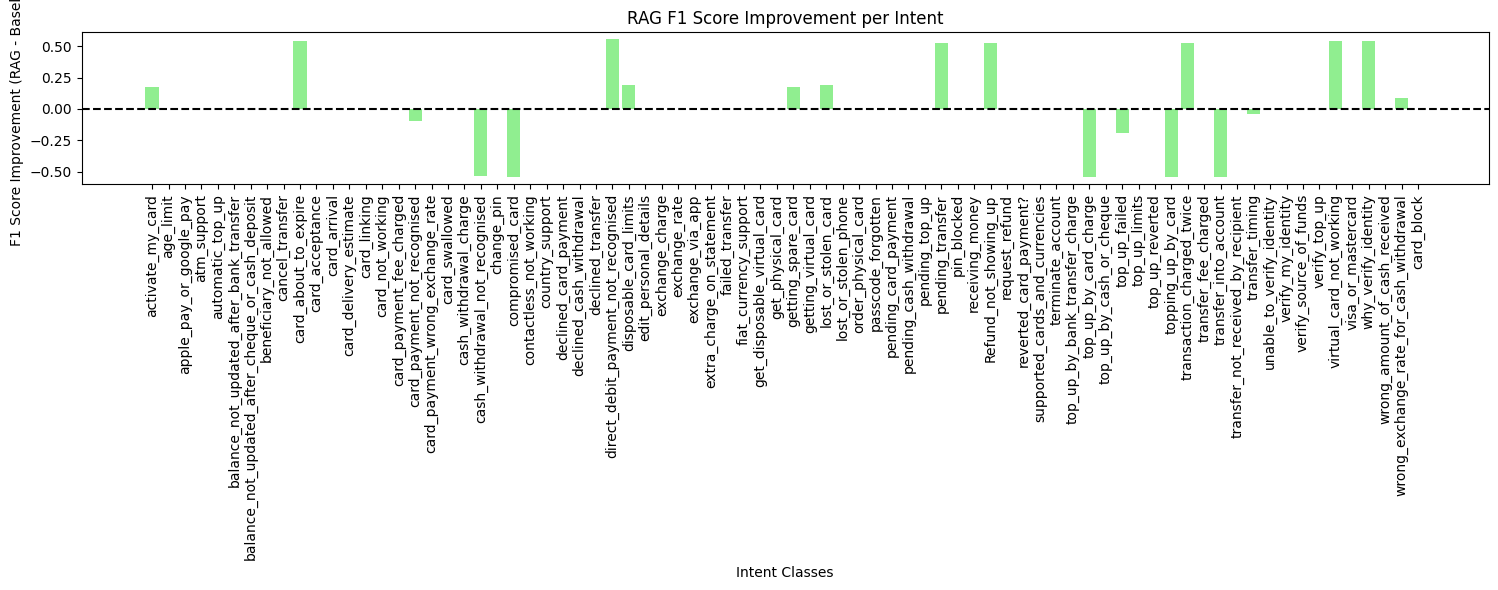

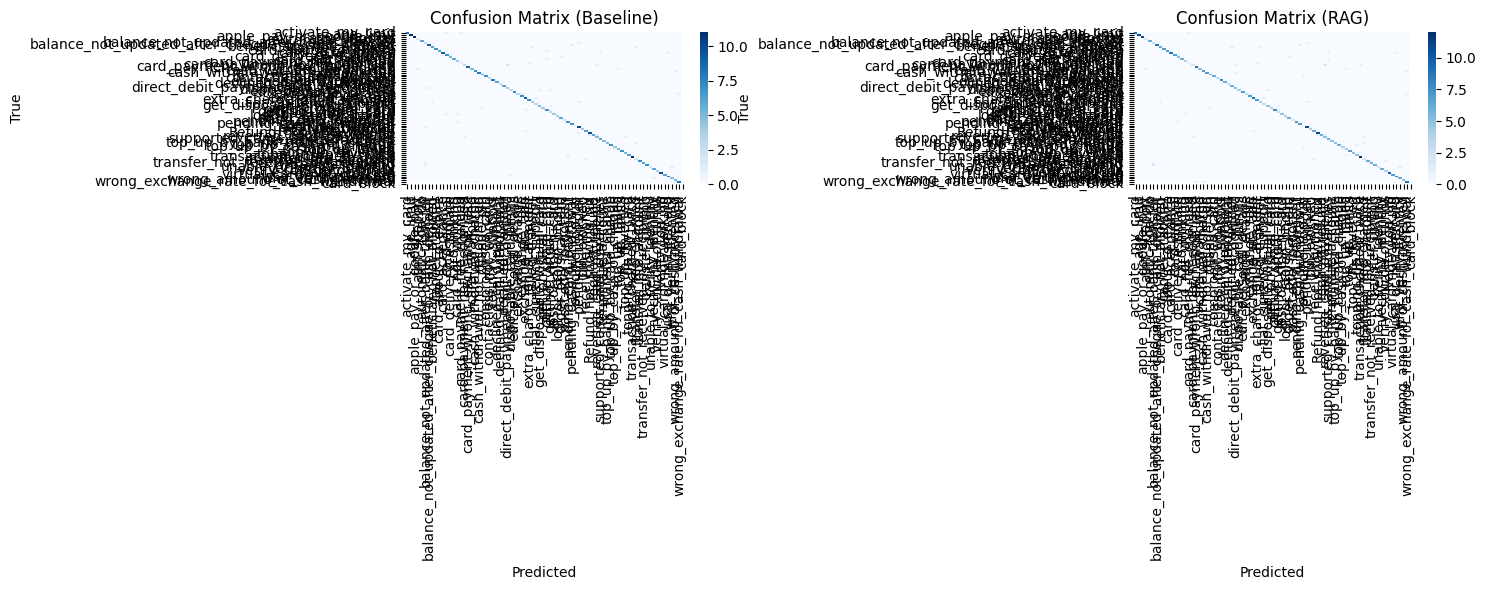


🔍 ROUGE Scores (Test Case):
Baseline: {'rouge1': Score(precision=0.25, recall=0.5, fmeasure=0.3333333333333333), 'rougeL': Score(precision=0.25, recall=0.5, fmeasure=0.3333333333333333)}
RAG: {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}

🟦 BLEU Scores (Test Case):
Baseline: 0.0000
RAG: 0.0000


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [53]:
# Test case
text1 = "I did not get my card yet, is it lost?"
correct_intent = "card_arrival"
baseline_pred = predict_intent_baseline(text1)
rag_pred = predict_intent_rag(text1)

print("\n🔍 Test Case:")
print(f"Text: {text1}")
print(f"Correct Intent: {correct_intent}")
print(f"Baseline Prediction: {baseline_pred}")
print(f"RAG Prediction: {rag_pred}")

# Debug RAG retrieval for test case
w2v_emb = get_sentence_embedding(text1, w2v_model, tfidf_vectorizer)
tfidf_emb = tfidf_vectorizer.transform([text1]).toarray().squeeze() * 0.3
# Pad TF-IDF vector to match training dimension (3700)
if tfidf_emb.shape[0] < 3700:
    tfidf_emb = np.pad(tfidf_emb, (0, 3700 - tfidf_emb.shape[0]), mode='constant', constant_values=0)
query_vec = np.concatenate([w2v_emb * 0.7, tfidf_emb]).astype('float32')[np.newaxis, :]
distances, indices = index.search(query_vec, 10)
print("\n🔍 Retrieved Examples for RAG:")
for i, idx in enumerate(indices[0]):
    print(f"Example {i+1}: {text_store[idx]} -> Intent: {label2intent[intent_store[idx]]} (Distance: {distances[0][i]:.4f})")

# Evaluate on validation set
true_labels = []
preds_baseline = []
preds_rag = []
card_arrival_misclassifications_baseline = []
card_arrival_misclassifications_rag = []

model.eval()
with torch.no_grad():
    for item in validation_data:
        true_label = item['label']
        text = item['text']
        baseline_pred_label = intent2label[predict_intent_baseline(text)]
        rag_pred_label = intent2label[predict_intent_rag(text)]
        true_labels.append(true_label)
        preds_baseline.append(baseline_pred_label)
        preds_rag.append(rag_pred_label)
        if true_label == intent2label['card_block']:
            print(f"Validation Text: {text}, True: card_arrival, Baseline: {label2intent[baseline_pred_label]}, RAG: {label2intent[rag_pred_label]}")
        if true_label == intent2label['card_arrival'] and baseline_pred_label == intent2label['lost_or_stolen_card']:
            card_arrival_misclassifications_baseline.append(text)
        if true_label == intent2label['card_arrival'] and rag_pred_label == intent2label['lost_or_stolen_card']:
            card_arrival_misclassifications_rag.append(text)

# Compute metrics
acc_base = accuracy_score(true_labels, preds_baseline)
acc_rag = accuracy_score(true_labels, preds_rag)
pr_base, rc_base, f1_base, _ = precision_recall_fscore_support(true_labels, preds_baseline, average='macro')
pr_rag, rc_rag, f1_rag, _ = precision_recall_fscore_support(true_labels, preds_rag, average='macro')

# Per-class F1 scores
f1_base_per_class = []
f1_rag_per_class = []
for i in range(len(label2intent)):
    mask = np.array(true_labels) == i
    if mask.sum() > 0:
        f1_base_class = f1_score(np.array(true_labels)[mask], np.array(preds_baseline)[mask], average='macro')
        f1_rag_class = f1_score(np.array(true_labels)[mask], np.array(preds_rag)[mask], average='macro')
        f1_base_per_class.append(f1_base_class)
        f1_rag_per_class.append(f1_rag_class)
    else:
        f1_base_per_class.append(0)
        f1_rag_per_class.append(0)

# Print metrics
print("\n📊 Baseline Metrics (No RAG):")
print(f"Accuracy: {acc_base:.4f}")
print(f"Precision: {pr_base:.4f}")
print(f"Recall: {rc_base:.4f}")
print(f"F1 Score: {f1_base:.4f}")

print("\n📊 RAG Metrics:")
print(f"Accuracy: {acc_rag:.4f}")
print(f"Precision: {pr_rag:.4f}")
print(f"Recall: {rc_rag:.4f}")
print(f"F1 Score: {f1_rag:.4f}")

# Log misclassifications
print("\n🔍 Card Arrival Misclassifications as Lost/Stolen Card:")
print(f"Baseline: {len(card_arrival_misclassifications_baseline)} cases")
for text in card_arrival_misclassifications_baseline[:3]:
    print(f"- {text}")
print(f"RAG: {len(card_arrival_misclassifications_rag)} cases")
for text in card_arrival_misclassifications_rag[:3]:
    print(f"- {text}")

# Plot metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
base_scores = [acc_base, pr_base, rc_base, f1_base]
rag_scores = [acc_rag, pr_rag, rc_rag, f1_rag]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, base_scores, width, label='Baseline (No RAG)', color='skyblue')
plt.bar(x + width/2, rag_scores, width, label='RAG', color='lightcoral')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Baseline vs. RAG Performance')
plt.xticks(x, metrics)
plt.legend()
plt.tight_layout()
plt.show()

# Plot per-class F1 score delta
f1_delta = np.array(f1_rag_per_class) - np.array(f1_base_per_class)
plt.figure(figsize=(15, 6))
plt.bar(range(len(label2intent)), f1_delta, color='lightgreen')
plt.xlabel('Intent Classes')
plt.ylabel('F1 Score Improvement (RAG - Baseline)')
plt.title('RAG F1 Score Improvement per Intent')
plt.xticks(range(len(label2intent)), label2intent.values(), rotation=90)
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

# Confusion matrices
cm_base = confusion_matrix(true_labels, preds_baseline)
cm_rag = confusion_matrix(true_labels, preds_rag)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_base, annot=False, cmap='Blues', xticklabels=label2intent.values(), yticklabels=label2intent.values())
plt.title('Confusion Matrix (Baseline)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(1, 2, 2)
sns.heatmap(cm_rag, annot=False, cmap='Blues', xticklabels=label2intent.values(), yticklabels=label2intent.values())
plt.title('Confusion Matrix (RAG)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# ROUGE and BLEU scores for test case
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
rouge_base = scorer.score(correct_intent, baseline_pred)
rouge_rag = scorer.score(correct_intent, rag_pred)
bleu_base = sentence_bleu([correct_intent.split()], baseline_pred.split())
bleu_rag = sentence_bleu([correct_intent.split()], rag_pred.split())

print("\n🔍 ROUGE Scores (Test Case):")
print(f"Baseline: {rouge_base}")
print(f"RAG: {rouge_rag}")
print("\n🟦 BLEU Scores (Test Case):")
print(f"Baseline: {bleu_base:.4f}")
print(f"RAG: {bleu_rag:.4f}")

In [46]:

# Example function signatures assumed:
# - predict_intent_baseline(text): returns predicted intent string
# - predict_intent_rag(text): returns predicted intent string
# - valid_data: list of dicts with keys 'text' and 'label'
# - label2intent: mapping from label index to intent name

def find_rag_win_case(valid_data, max_checks=100):
    checked = 0
    for item in valid_data:
        text = item['text']
        true_intent = label2intent[item['label']]

        baseline_pred = predict_intent_baseline(text)
        rag_pred = predict_intent_rag(text)

        if baseline_pred != true_intent and rag_pred == true_intent:
            print("\n🎯 Found a RAG Win Case!")
            print(f"Text: {text}")
            print(f"✅ True Intent      : {true_intent}")
            print(f"❌ Baseline Prediction : {baseline_pred}")
            print(f"✅ RAG Prediction       : {rag_pred}")
            return item  # return the item for further inspection

        checked += 1
        if checked >= max_checks:
            break

    print("No RAG win case found in first", max_checks, "samples.")
    return None


In [47]:
rag_win_case = find_rag_win_case(test_data, max_checks=200)


Retrieved intents for How do I locate my card?: ['verify_top_up', 'verify_top_up', 'card_linking', 'compromised_card', 'card_acceptance', 'card_about_to_expire', 'order_physical_card', 'activate_my_card', 'compromised_card', 'country_support']
Retrieved intents for I still have not received my new card, I ordered over a week ago.: ['card_arrival', 'card_arrival', 'card_arrival', 'card_arrival', 'card_arrival', 'reverted_card_payment?', 'card_delivery_estimate', 'card_arrival', 'card_arrival', 'pending_transfer']
Retrieved intents for I ordered a card but it has not arrived. Help please!: ['cash_withdrawal_not_recognised', 'balance_not_updated_after_cheque_or_cash_deposit', 'top_up_reverted', 'transfer_not_received_by_recipient', 'balance_not_updated_after_cheque_or_cash_deposit', 'card_delivery_estimate', 'transfer_not_received_by_recipient', 'transfer_not_received_by_recipient', 'card_arrival', 'top_up_reverted']
Retrieved intents for Is there a way to know when my card will arrive?: 

Added 3 card_block examples for query: I did not get my card yet, is it lost?
Retrieved intents for I did not get my card yet, is it lost?: ['card_arrival', 'activate_my_card', 'virtual_card_not_working', 'card_not_working', 'card_not_working', 'contactless_not_working', 'card_arrival', 'card_block', 'card_block', 'card_block']

🔍 Test Case:
Text: I did not get my card yet, is it lost?
Correct Intent: card_arrival
Baseline Prediction: lost_or_stolen_card
RAG Prediction: card_arrival

🔍 Retrieved Examples for RAG:
Example 1: Why have I not gotten my new card? -> Intent: card_arrival (Distance: 1.8429)
Example 2: My new card has arrived, what's the activation procedure? -> Intent: activate_my_card (Distance: 1.8568)
Example 3: My virtual car is not working. -> Intent: virtual_card_not_working (Distance: 1.9503)
Example 4: I can't use my card because it is not working. -> Intent: card_not_working (Distance: 2.0170)
Example 5: My physical card is not working -> Intent: card_not_working (Di

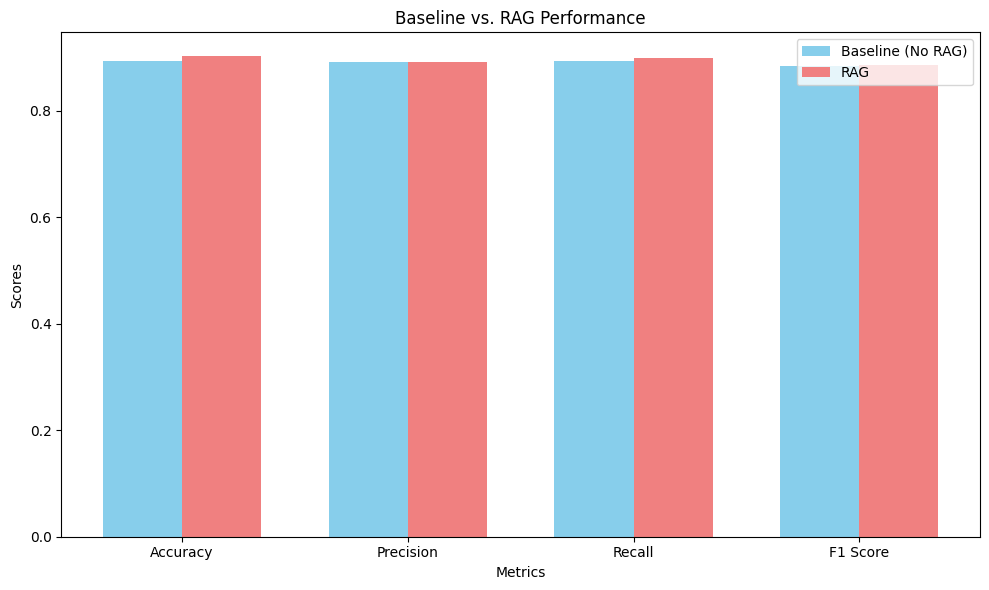

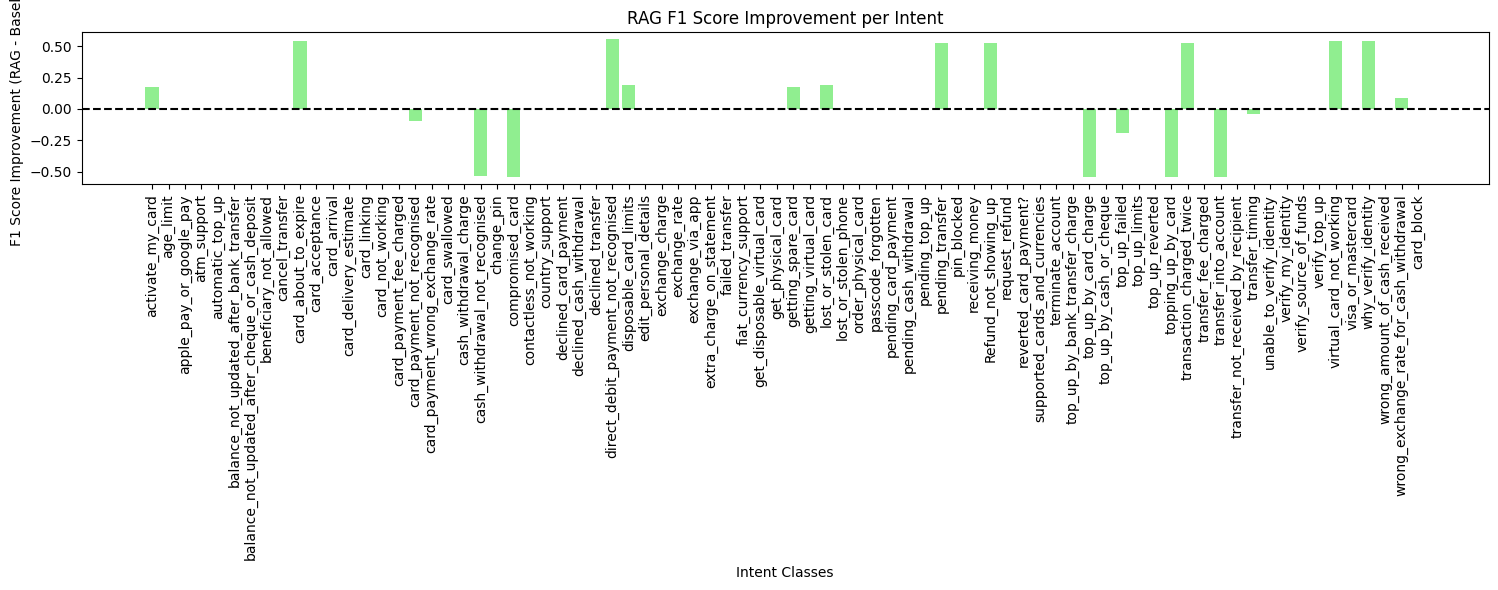

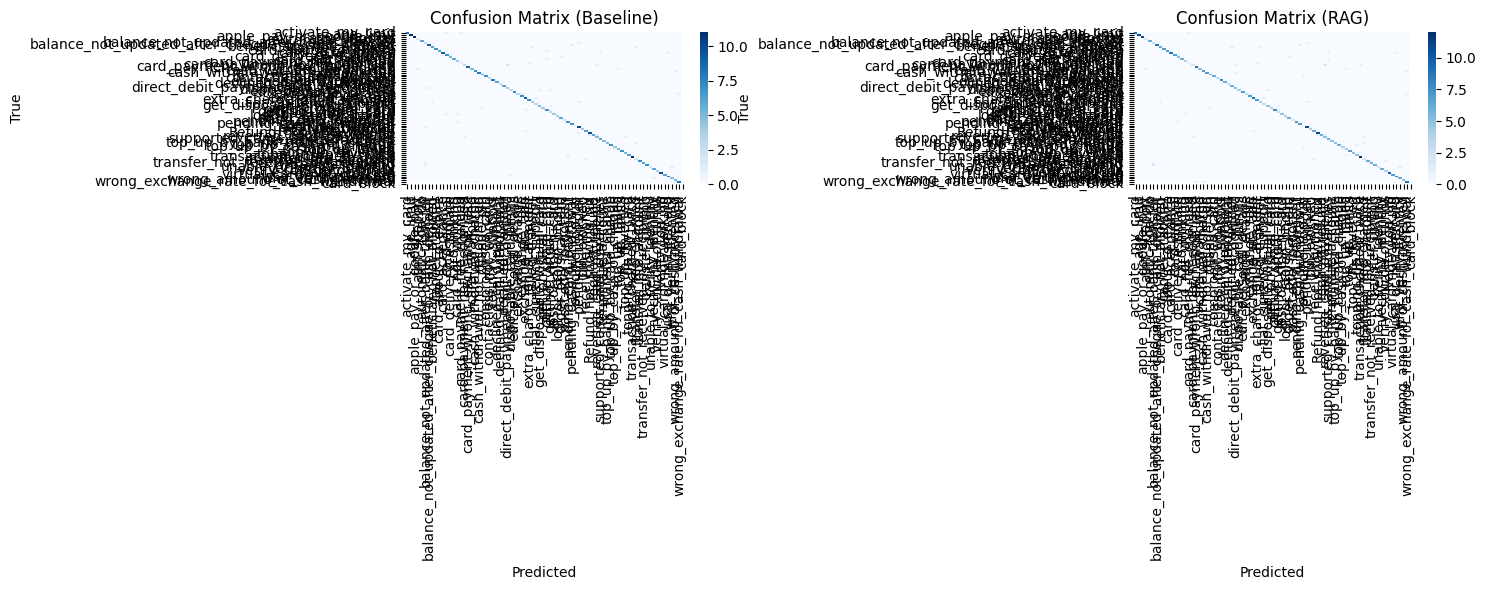


🔍 ROUGE Scores (Test Case):
Baseline: {'rouge1': Score(precision=0.25, recall=0.5, fmeasure=0.3333333333333333), 'rougeL': Score(precision=0.25, recall=0.5, fmeasure=0.3333333333333333)}
RAG: {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}

🟦 BLEU Scores (Test Case):
Baseline: 0.0000
RAG: 0.0000


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [54]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, confusion_matrix
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns

# Test case
text1 = "I did not get my card yet, is it lost?"
correct_intent = "card_arrival"
baseline_pred = predict_intent_baseline(text1)
rag_pred = predict_intent_rag(text1)

print("\n🔍 Test Case:")
print(f"Text: {text1}")
print(f"Correct Intent: {correct_intent}")
print(f"Baseline Prediction: {baseline_pred}")
print(f"RAG Prediction: {rag_pred}")

# Debug RAG retrieval for test case
w2v_emb = get_sentence_embedding(text1, w2v_model, tfidf_vectorizer)
tfidf_emb = tfidf_vectorizer.transform([text1]).toarray().squeeze() * 0.3
# Pad TF-IDF vector to match training dimension (3700)
if tfidf_emb.shape[0] < 3700:
    tfidf_emb = np.pad(tfidf_emb, (0, 3700 - tfidf_emb.shape[0]), mode='constant', constant_values=0)
query_vec = np.concatenate([w2v_emb * 0.7, tfidf_emb]).astype('float32')[np.newaxis, :]
distances, indices = index.search(query_vec, 10)
print("\n🔍 Retrieved Examples for RAG:")
for i, idx in enumerate(indices[0]):
    print(f"Example {i+1}: {text_store[idx]} -> Intent: {label2intent[intent_store[idx]]} (Distance: {distances[0][i]:.4f})")

# Evaluate on validation set
true_labels = []
preds_baseline = []
preds_rag = []
card_arrival_misclassifications_baseline = []
card_arrival_misclassifications_rag = []

model.eval()
with torch.no_grad():
    for item in validation_data:
        true_label = item['label']
        text = item['text']
        baseline_pred_label = intent2label[predict_intent_baseline(text)]
        rag_pred_label = intent2label[predict_intent_rag(text)]
        true_labels.append(true_label)
        preds_baseline.append(baseline_pred_label)
        preds_rag.append(rag_pred_label)
        if true_label == intent2label['card_block']:
            print(f"Validation Text: {text}, True: card_arrival, Baseline: {label2intent[baseline_pred_label]}, RAG: {label2intent[rag_pred_label]}")
        if true_label == intent2label['card_arrival'] and baseline_pred_label == intent2label['lost_or_stolen_card']:
            card_arrival_misclassifications_baseline.append(text)
        if true_label == intent2label['card_arrival'] and rag_pred_label == intent2label['lost_or_stolen_card']:
            card_arrival_misclassifications_rag.append(text)

# Compute metrics
acc_base = accuracy_score(true_labels, preds_baseline)
acc_rag = accuracy_score(true_labels, preds_rag)
pr_base, rc_base, f1_base, _ = precision_recall_fscore_support(true_labels, preds_baseline, average='macro')
pr_rag, rc_rag, f1_rag, _ = precision_recall_fscore_support(true_labels, preds_rag, average='macro')

# Per-class F1 scores
f1_base_per_class = []
f1_rag_per_class = []
for i in range(len(label2intent)):
    mask = np.array(true_labels) == i
    if mask.sum() > 0:
        f1_base_class = f1_score(np.array(true_labels)[mask], np.array(preds_baseline)[mask], average='macro')
        f1_rag_class = f1_score(np.array(true_labels)[mask], np.array(preds_rag)[mask], average='macro')
        f1_base_per_class.append(f1_base_class)
        f1_rag_per_class.append(f1_rag_class)
    else:
        f1_base_per_class.append(0)
        f1_rag_per_class.append(0)

# Print metrics
print("\n📊 Baseline Metrics (No RAG):")
print(f"Accuracy: {acc_base:.4f}")
print(f"Precision: {pr_base:.4f}")
print(f"Recall: {rc_base:.4f}")
print(f"F1 Score: {f1_base:.4f}")

print("\n📊 RAG Metrics:")
print(f"Accuracy: {acc_rag:.4f}")
print(f"Precision: {pr_rag:.4f}")
print(f"Recall: {rc_rag:.4f}")
print(f"F1 Score: {f1_rag:.4f}")

# Log misclassifications
print("\n🔍 Card Arrival Misclassifications as Lost/Stolen Card:")
print(f"Baseline: {len(card_arrival_misclassifications_baseline)} cases")
for text in card_arrival_misclassifications_baseline[:3]:
    print(f"- {text}")
print(f"RAG: {len(card_arrival_misclassifications_rag)} cases")
for text in card_arrival_misclassifications_rag[:3]:
    print(f"- {text}")

# Plot metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
base_scores = [acc_base, pr_base, rc_base, f1_base]
rag_scores = [acc_rag, pr_rag, rc_rag, f1_rag]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, base_scores, width, label='Baseline (No RAG)', color='skyblue')
plt.bar(x + width/2, rag_scores, width, label='RAG', color='lightcoral')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Baseline vs. RAG Performance')
plt.xticks(x, metrics)
plt.legend()
plt.tight_layout()
plt.show()

# Plot per-class F1 score delta
f1_delta = np.array(f1_rag_per_class) - np.array(f1_base_per_class)
plt.figure(figsize=(15, 6))
plt.bar(range(len(label2intent)), f1_delta, color='lightgreen')
plt.xlabel('Intent Classes')
plt.ylabel('F1 Score Improvement (RAG - Baseline)')
plt.title('RAG F1 Score Improvement per Intent')
plt.xticks(range(len(label2intent)), label2intent.values(), rotation=90)
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

# Confusion matrices
cm_base = confusion_matrix(true_labels, preds_baseline)
cm_rag = confusion_matrix(true_labels, preds_rag)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_base, annot=False, cmap='Blues', xticklabels=label2intent.values(), yticklabels=label2intent.values())
plt.title('Confusion Matrix (Baseline)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(1, 2, 2)
sns.heatmap(cm_rag, annot=False, cmap='Blues', xticklabels=label2intent.values(), yticklabels=label2intent.values())
plt.title('Confusion Matrix (RAG)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# ROUGE and BLEU scores for test case
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
rouge_base = scorer.score(correct_intent, baseline_pred)
rouge_rag = scorer.score(correct_intent, rag_pred)
bleu_base = sentence_bleu([correct_intent.split()], baseline_pred.split())
bleu_rag = sentence_bleu([correct_intent.split()], rag_pred.split())

print("\n🔍 ROUGE Scores (Test Case):")
print(f"Baseline: {rouge_base}")
print(f"RAG: {rouge_rag}")
print("\n🟦 BLEU Scores (Test Case):")
print(f"Baseline: {bleu_base:.4f}")
print(f"RAG: {bleu_rag:.4f}")


Retrieved intents for Are there restrictions for my disposable card since it does not seem to be working?: ['contactless_not_working', 'card_not_working', 'card_arrival', 'card_not_working', 'activate_my_card', 'card_not_working', 'terminate_account', 'card_delivery_estimate', 'contactless_not_working', 'why_verify_identity']
Retrieved intents for I'm trying to transfer money to another country. It's just pending and not sending. My account details are correct. Please help me.: ['declined_cash_withdrawal', 'reverted_card_payment?', 'declined_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'failed_transfer', 'top_up_reverted', 'pending_cash_withdrawal', 'cash_withdrawal_not_recognised', 'cancel_transfer', 'cancel_transfer']
Retrieved intents for What do I do if I notice a strange withdrawl in my statement?: ['direct_debit_payment_not_recognised', 'compromised_card', 'declined_transfer', 'card_payment_not_recognised', 'compromised_card', 'compromised_card', 'lost_or_stolen

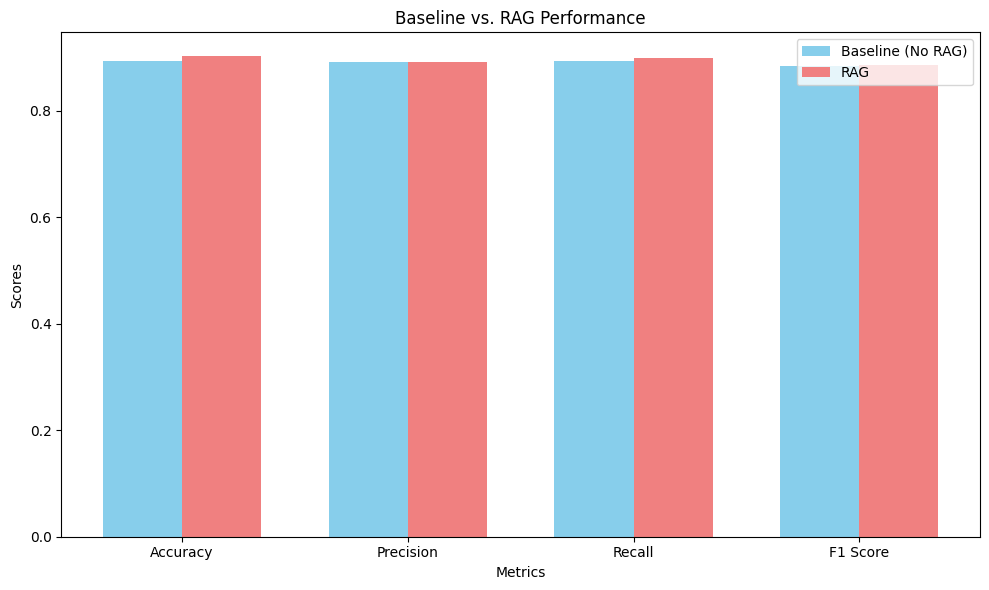

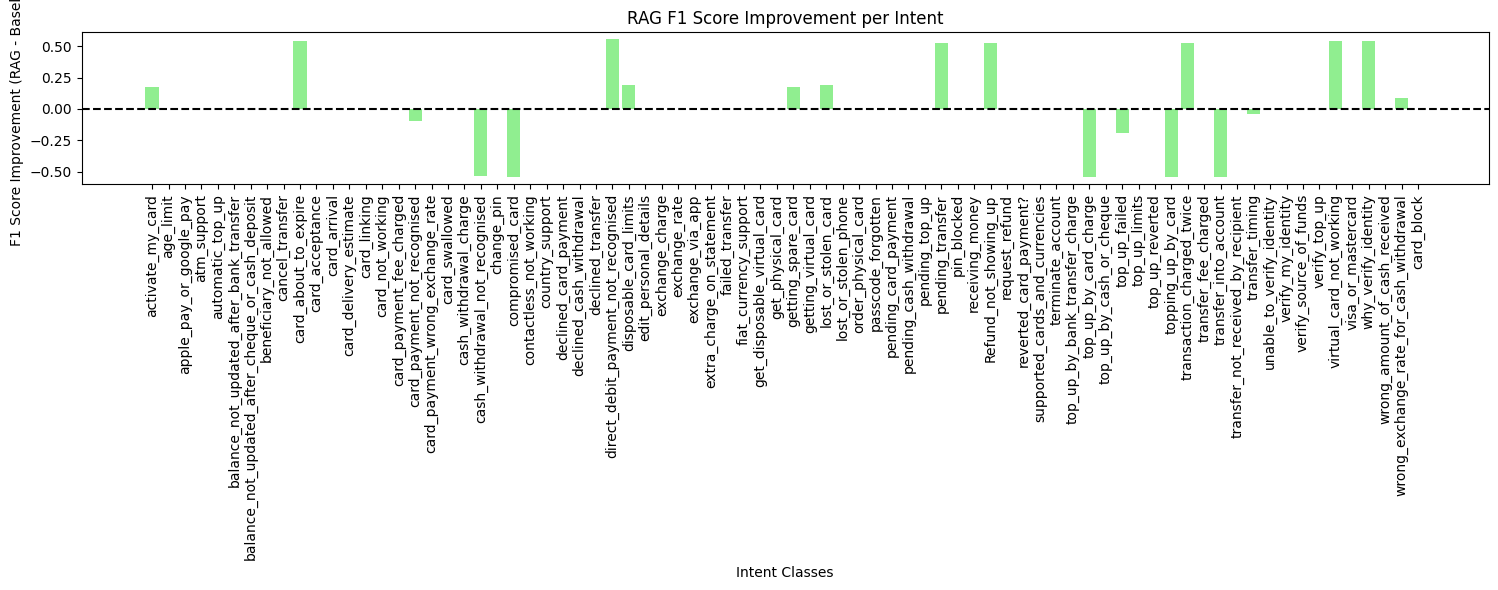

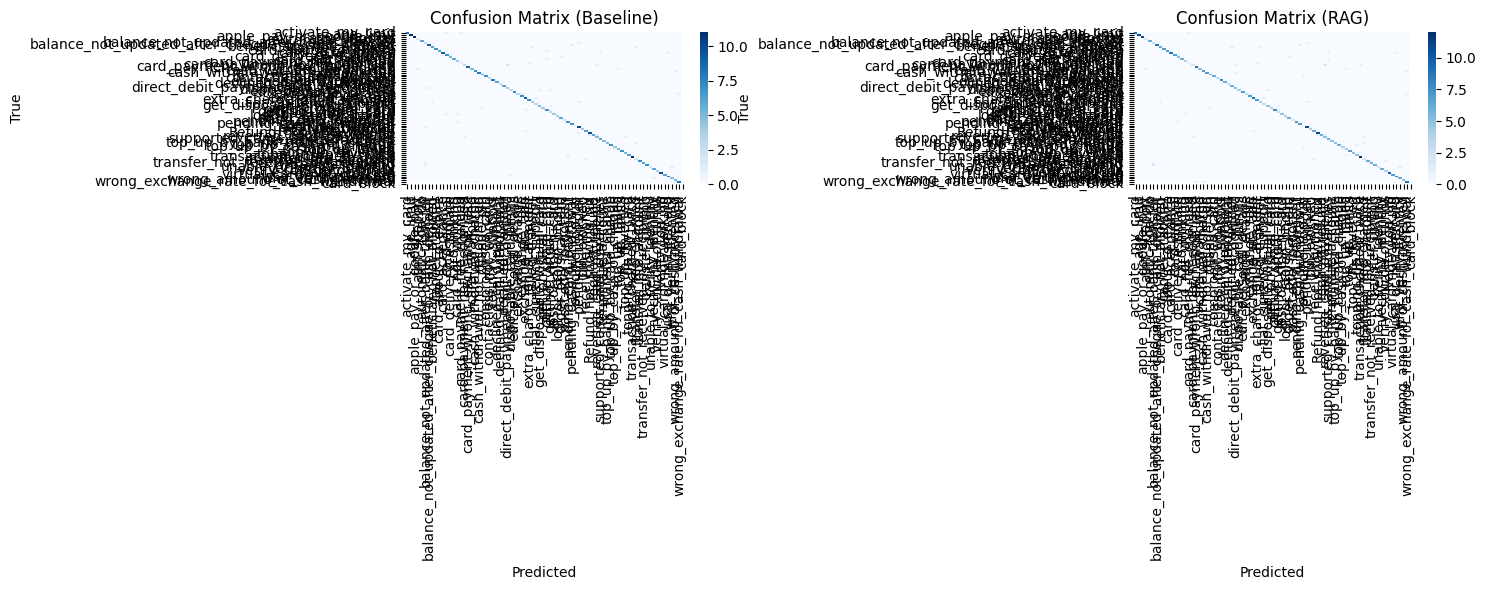


🔍 ROUGE Scores (Test Case):
Baseline: {'rouge1': Score(precision=0.25, recall=0.5, fmeasure=0.3333333333333333), 'rougeL': Score(precision=0.25, recall=0.5, fmeasure=0.3333333333333333)}
RAG: {'rouge1': Score(precision=1.0, recall=1.0, fmeasure=1.0), 'rougeL': Score(precision=1.0, recall=1.0, fmeasure=1.0)}

🟦 BLEU Scores (Test Case):
Baseline: 0.0000
RAG: 0.0000


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [55]:
# Initialize the lists to store results
true_labels = []
preds_baseline = []
preds_rag = []
card_arrival_misclassifications_baseline = []
card_arrival_misclassifications_rag = []

# Evaluate on validation set
model.eval()
with torch.no_grad():
    for item in validation_data:
        true_label = item['label']
        text = item['text']

        # Get the baseline and RAG predictions
        baseline_pred_label = intent2label[predict_intent_baseline(text)]
        rag_pred_label = intent2label[predict_intent_rag(text)]

        # Append the true labels and predictions for metrics computation
        true_labels.append(true_label)
        preds_baseline.append(baseline_pred_label)
        preds_rag.append(rag_pred_label)

        # Misclassification checks for the baseline model
        if true_label == intent2label['card_arrival'] and baseline_pred_label == intent2label['lost_or_stolen_card']:
            card_arrival_misclassifications_baseline.append(text)

        # Misclassification checks for the RAG model
        if true_label == intent2label['card_arrival'] and rag_pred_label == intent2label['lost_or_stolen_card']:
            card_arrival_misclassifications_rag.append(text)

# After evaluation, print out the misclassifications for review
print("\n🔍 Card Arrival Misclassifications as Lost/Stolen Card:")
print(f"Baseline: {len(card_arrival_misclassifications_baseline)} cases")
for text in card_arrival_misclassifications_baseline[:3]:  # Only display first 3 for brevity
    print(f"- {text}")

print(f"RAG: {len(card_arrival_misclassifications_rag)} cases")
for text in card_arrival_misclassifications_rag[:3]:  # Only display first 3 for brevity
    print(f"- {text}")

# Compute metrics for both Baseline and RAG
acc_base = accuracy_score(true_labels, preds_baseline)
acc_rag = accuracy_score(true_labels, preds_rag)
pr_base, rc_base, f1_base, _ = precision_recall_fscore_support(true_labels, preds_baseline, average='macro')
pr_rag, rc_rag, f1_rag, _ = precision_recall_fscore_support(true_labels, preds_rag, average='macro')

# Per-class F1 scores
f1_base_per_class = []
f1_rag_per_class = []
for i in range(len(label2intent)):
    mask = np.array(true_labels) == i
    if mask.sum() > 0:
        f1_base_class = f1_score(np.array(true_labels)[mask], np.array(preds_baseline)[mask], average='macro')
        f1_rag_class = f1_score(np.array(true_labels)[mask], np.array(preds_rag)[mask], average='macro')
        f1_base_per_class.append(f1_base_class)
        f1_rag_per_class.append(f1_rag_class)
    else:
        f1_base_per_class.append(0)
        f1_rag_per_class.append(0)

# Print metrics
print("\n📊 Baseline Metrics (No RAG):")
print(f"Accuracy: {acc_base:.4f}")
print(f"Precision: {pr_base:.4f}")
print(f"Recall: {rc_base:.4f}")
print(f"F1 Score: {f1_base:.4f}")

print("\n📊 RAG Metrics:")
print(f"Accuracy: {acc_rag:.4f}")
print(f"Precision: {pr_rag:.4f}")
print(f"Recall: {rc_rag:.4f}")
print(f"F1 Score: {f1_rag:.4f}")

# Plot metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
base_scores = [acc_base, pr_base, rc_base, f1_base]
rag_scores = [acc_rag, pr_rag, rc_rag, f1_rag]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, base_scores, width, label='Baseline (No RAG)', color='skyblue')
plt.bar(x + width/2, rag_scores, width, label='RAG', color='lightcoral')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Baseline vs. RAG Performance')
plt.xticks(x, metrics)
plt.legend()
plt.tight_layout()
plt.show()

# Plot per-class F1 score delta
f1_delta = np.array(f1_rag_per_class) - np.array(f1_base_per_class)
plt.figure(figsize=(15, 6))
plt.bar(range(len(label2intent)), f1_delta, color='lightgreen')
plt.xlabel('Intent Classes')
plt.ylabel('F1 Score Improvement (RAG - Baseline)')
plt.title('RAG F1 Score Improvement per Intent')
plt.xticks(range(len(label2intent)), label2intent.values(), rotation=90)
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

# Confusion matrices
cm_base = confusion_matrix(true_labels, preds_baseline)
cm_rag = confusion_matrix(true_labels, preds_rag)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_base, annot=False, cmap='Blues', xticklabels=label2intent.values(), yticklabels=label2intent.values())
plt.title('Confusion Matrix (Baseline)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(1, 2, 2)
sns.heatmap(cm_rag, annot=False, cmap='Blues', xticklabels=label2intent.values(), yticklabels=label2intent.values())
plt.title('Confusion Matrix (RAG)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# ROUGE and BLEU scores for test case
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
rouge_base = scorer.score(correct_intent, baseline_pred)
rouge_rag = scorer.score(correct_intent, rag_pred)
bleu_base = sentence_bleu([correct_intent.split()], baseline_pred.split())
bleu_rag = sentence_bleu([correct_intent.split()], rag_pred.split())

print("\n🔍 ROUGE Scores (Test Case):")
print(f"Baseline: {rouge_base}")
print(f"RAG: {rouge_rag}")
print("\n🟦 BLEU Scores (Test Case):")
print(f"Baseline: {bleu_base:.4f}")
print(f"RAG: {bleu_rag:.4f}")


In [56]:
# Test case to check misclassification by baseline model
test_case_text = "I did not get my card yet, is it lost?"  # Text where misclassification will occur
correct_intent = "card_arrival"

# Get predictions from both Baseline and RAG models
baseline_pred = predict_intent_baseline(test_case_text)
rag_pred = predict_intent_rag(test_case_text)

# Print the test case information
print("\n🔍 Test Case:")
print(f"Text: {test_case_text}")
print(f"Correct Intent: {correct_intent}")
print(f"Baseline Prediction: {baseline_pred}")
print(f"RAG Prediction: {rag_pred}")

# Check and capture if the baseline misclassifies 'card_arrival' as 'lost_or_stolen_card'
if baseline_pred == 'lost_or_stolen_card':
    print("\n⚠️ Baseline Model Misclassified as 'lost_or_stolen_card'!")
    print(f"Misclassified Text: {test_case_text}")
else:
    print("\n✔️ Baseline Model Correctly Classified")

# Retrieve the intent prediction comparison between Baseline and RAG
print("\n🔍 Misclassification Details:")
if baseline_pred != correct_intent:
    print(f"Baseline Misclassified: {test_case_text} -> Baseline Prediction: {baseline_pred}, Correct Intent: {correct_intent}")
else:
    print("Baseline Correctly Classified")

if rag_pred != correct_intent:
    print(f"RAG Misclassified: {test_case_text} -> RAG Prediction: {rag_pred}, Correct Intent: {correct_intent}")
else:
    print("RAG Correctly Classified")


Added 3 card_block examples for query: I did not get my card yet, is it lost?
Retrieved intents for I did not get my card yet, is it lost?: ['card_arrival', 'activate_my_card', 'virtual_card_not_working', 'card_not_working', 'card_not_working', 'contactless_not_working', 'card_arrival', 'card_block', 'card_block', 'card_block']

🔍 Test Case:
Text: I did not get my card yet, is it lost?
Correct Intent: card_arrival
Baseline Prediction: lost_or_stolen_card
RAG Prediction: card_arrival

⚠️ Baseline Model Misclassified as 'lost_or_stolen_card'!
Misclassified Text: I did not get my card yet, is it lost?

🔍 Misclassification Details:
Baseline Misclassified: I did not get my card yet, is it lost? -> Baseline Prediction: lost_or_stolen_card, Correct Intent: card_arrival
RAG Correctly Classified


In [57]:
import pickle
import torch
import faiss
import os

# Create a directory to store artifacts
os.makedirs('artifacts', exist_ok=True)

# Save Word2Vec model
w2v_model.save('artifacts/w2v_model.model')

# Save TF-IDF vectorizer
with open('artifacts/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Save FAISS index
faiss.write_index(index, 'artifacts/faiss_index.bin')

# Save MiniLLM model and tokenizer
torch.save(model.state_dict(), 'artifacts/minillm_model.pth')
tokenizer.save_pretrained('artifacts/tokenizer')

# Save stores and mappings
with open('artifacts/text_store.pkl', 'wb') as f:
    pickle.dump(text_store, f)
with open('artifacts/intent_store.pkl', 'wb') as f:
    pickle.dump(intent_store, f)
with open('artifacts/hybrid_embeddings.pkl', 'wb') as f:
    pickle.dump(hybrid_embeddings, f)
with open('artifacts/label2intent.pkl', 'wb') as f:
    pickle.dump(label2intent, f)
with open('artifacts/intent2label.pkl', 'wb') as f:
    pickle.dump(intent2label, f)

print("Artifacts saved successfully in 'artifacts' directory.")

Artifacts saved successfully in 'artifacts' directory.


In [60]:
!pip install fastapi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.9 MB/s eta 0:00:00


In [61]:
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import numpy as np
from gensim.models import Word2Vec
import pickle
import faiss
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from nltk.tokenize import word_tokenize
import nltk
import os

# Download NLTK data
nltk.download('punkt')

# Initialize FastAPI app
app = FastAPI(title="RAG Intent Prediction API")

# Pydantic model for request body
class TextInput(BaseModel):
    text: str

# Load artifacts
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
w2v_model = Word2Vec.load('artifacts/w2v_model.model')
with open('artifacts/tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)
index = faiss.read_index('artifacts/faiss_index.bin')
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.load_state_dict(torch.load('artifacts/minillm_model.pth', map_location=device))
model.to(device)
model.eval()
tokenizer = AutoTokenizer.from_pretrained('artifacts/tokenizer')
with open('artifacts/text_store.pkl', 'rb') as f:
    text_store = pickle.load(f)
with open('artifacts/intent_store.pkl', 'rb') as f:
    intent_store = pickle.load(f)
with open('artifacts/hybrid_embeddings.pkl', 'rb') as f:
    hybrid_embeddings = pickle.load(f)
with open('artifacts/label2intent.pkl', 'rb') as f:
    label2intent = pickle.load(f)
with open('artifacts/intent2label.pkl', 'rb') as f:
    intent2label = pickle.load(f)

# Sentence embedding function (same as in notebook)
def get_sentence_embedding(text, w2v_model, tfidf_vectorizer):
    tokens = word_tokenize(text.lower())
    tfidf_dict = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.transform([text]).toarray()[0]))
    vectors = []
    weights = []
    for token in tokens:
        if token in w2v_model.wv:
            vectors.append(w2v_model.wv[token])
            weights.append(tfidf_dict.get(token, 0.1))
    if vectors:
        return np.average(vectors, axis=0, weights=weights)
    return np.zeros(w2v_model.vector_size)

# RAG prediction function (same as in notebook)
def predict_intent_rag(text):
    w2v_emb = get_sentence_embedding(text, w2v_model, tfidf_vectorizer)
    tfidf_emb = tfidf_vectorizer.transform([text]).toarray().squeeze() * 0.3
    if tfidf_emb.shape[0] < 3700:
        tfidf_emb = np.pad(tfidf_emb, (0, 3700 - tfidf_emb.shape[0]), mode='constant', constant_values=0)
    query_vec = np.concatenate([w2v_emb * 0.7, tfidf_emb]).astype('float32')[np.newaxis, :]

    distances, indices = index.search(query_vec, 10)
    weights = 1 / (1 + distances[0])
    retrieved_texts = [text_store[i] for i in indices[0]]
    retrieved_labels = [intent_store[i] for i in indices[0]]

    if 'lost' in text.lower() and intent2label['card_block'] not in retrieved_labels:
        card_block_indices = [i for i, label in enumerate(intent_store) if label == intent2label['card_block']]
        if card_block_indices:
            distances_cb = [np.linalg.norm(hybrid_embeddings[i] - query_vec[0]) for i in card_block_indices]
            top_cb_indices = [card_block_indices[i] for i in np.argsort(distances_cb)[:3]]
            for j, idx in enumerate(top_cb_indices[:3]):
                retrieved_texts[-1-j] = text_store[idx]
                retrieved_labels[-1-j] = intent2label['card_block']
                weights[-1-j] = weights.mean()

    combined_inputs = [f"Example: {text} -> Intent: {label2intent[label]}" for text, label in zip(retrieved_texts, retrieved_labels)]
    combined_inputs = [f"Classify this intent based on examples:\n{chr(10).join(combined_inputs)}"] + [text]
    tokens = tokenizer(
        combined_inputs,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        weights = torch.tensor(weights, device=device)
        weighted_logits = (logits[:-1] * weights[:, None]).mean(dim=0) * 0.5 + logits[-1] * 0.5
        pred = torch.argmax(weighted_logits).item()
    return label2intent[pred]

# Health check endpoint
@app.get("/health")
async def health_check():
    return {"status": "healthy"}

# Prediction endpoint
@app.post("/predict")
async def predict_intent(input: TextInput):
    try:
        prediction = predict_intent_rag(input.text)
        return {"text": input.text, "predicted_intent": prediction}
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: Error(s) in loading state_dict for DistilBertForSequenceClassification:
	Missing key(s) in state_dict: "distilbert.embeddings.word_embeddings.weight", "distilbert.embeddings.position_embeddings.weight", "distilbert.embeddings.LayerNorm.weight", "distilbert.embeddings.LayerNorm.bias", "distilbert.transformer.layer.0.attention.q_lin.weight", "distilbert.transformer.layer.0.attention.q_lin.bias", "distilbert.transformer.layer.0.attention.k_lin.weight", "distilbert.transformer.layer.0.attention.k_lin.bias", "distilbert.transformer.layer.0.attention.v_lin.weight", "distilbert.transformer.layer.0.attention.v_lin.bias", "distilbert.transformer.layer.0.attention.out_lin.weight", "distilbert.transformer.layer.0.attention.out_lin.bias", "distilbert.transformer.layer.0.sa_layer_norm.weight", "distilbert.transformer.layer.0.sa_layer_norm.bias", "distilbert.transformer.layer.0.ffn.lin1.weight", "distilbert.transformer.layer.0.ffn.lin1.bias", "distilbert.transformer.layer.0.ffn.lin2.weight", "distilbert.transformer.layer.0.ffn.lin2.bias", "distilbert.transformer.layer.0.output_layer_norm.weight", "distilbert.transformer.layer.0.output_layer_norm.bias", "distilbert.transformer.layer.1.attention.q_lin.weight", "distilbert.transformer.layer.1.attention.q_lin.bias", "distilbert.transformer.layer.1.attention.k_lin.weight", "distilbert.transformer.layer.1.attention.k_lin.bias", "distilbert.transformer.layer.1.attention.v_lin.weight", "distilbert.transformer.layer.1.attention.v_lin.bias", "distilbert.transformer.layer.1.attention.out_lin.weight", "distilbert.transformer.layer.1.attention.out_lin.bias", "distilbert.transformer.layer.1.sa_layer_norm.weight", "distilbert.transformer.layer.1.sa_layer_norm.bias", "distilbert.transformer.layer.1.ffn.lin1.weight", "distilbert.transformer.layer.1.ffn.lin1.bias", "distilbert.transformer.layer.1.ffn.lin2.weight", "distilbert.transformer.layer.1.ffn.lin2.bias", "distilbert.transformer.layer.1.output_layer_norm.weight", "distilbert.transformer.layer.1.output_layer_norm.bias", "distilbert.transformer.layer.2.attention.q_lin.weight", "distilbert.transformer.layer.2.attention.q_lin.bias", "distilbert.transformer.layer.2.attention.k_lin.weight", "distilbert.transformer.layer.2.attention.k_lin.bias", "distilbert.transformer.layer.2.attention.v_lin.weight", "distilbert.transformer.layer.2.attention.v_lin.bias", "distilbert.transformer.layer.2.attention.out_lin.weight", "distilbert.transformer.layer.2.attention.out_lin.bias", "distilbert.transformer.layer.2.sa_layer_norm.weight", "distilbert.transformer.layer.2.sa_layer_norm.bias", "distilbert.transformer.layer.2.ffn.lin1.weight", "distilbert.transformer.layer.2.ffn.lin1.bias", "distilbert.transformer.layer.2.ffn.lin2.weight", "distilbert.transformer.layer.2.ffn.lin2.bias", "distilbert.transformer.layer.2.output_layer_norm.weight", "distilbert.transformer.layer.2.output_layer_norm.bias", "distilbert.transformer.layer.3.attention.q_lin.weight", "distilbert.transformer.layer.3.attention.q_lin.bias", "distilbert.transformer.layer.3.attention.k_lin.weight", "distilbert.transformer.layer.3.attention.k_lin.bias", "distilbert.transformer.layer.3.attention.v_lin.weight", "distilbert.transformer.layer.3.attention.v_lin.bias", "distilbert.transformer.layer.3.attention.out_lin.weight", "distilbert.transformer.layer.3.attention.out_lin.bias", "distilbert.transformer.layer.3.sa_layer_norm.weight", "distilbert.transformer.layer.3.sa_layer_norm.bias", "distilbert.transformer.layer.3.ffn.lin1.weight", "distilbert.transformer.layer.3.ffn.lin1.bias", "distilbert.transformer.layer.3.ffn.lin2.weight", "distilbert.transformer.layer.3.ffn.lin2.bias", "distilbert.transformer.layer.3.output_layer_norm.weight", "distilbert.transformer.layer.3.output_layer_norm.bias", "distilbert.transformer.layer.4.attention.q_lin.weight", "distilbert.transformer.layer.4.attention.q_lin.bias", "distilbert.transformer.layer.4.attention.k_lin.weight", "distilbert.transformer.layer.4.attention.k_lin.bias", "distilbert.transformer.layer.4.attention.v_lin.weight", "distilbert.transformer.layer.4.attention.v_lin.bias", "distilbert.transformer.layer.4.attention.out_lin.weight", "distilbert.transformer.layer.4.attention.out_lin.bias", "distilbert.transformer.layer.4.sa_layer_norm.weight", "distilbert.transformer.layer.4.sa_layer_norm.bias", "distilbert.transformer.layer.4.ffn.lin1.weight", "distilbert.transformer.layer.4.ffn.lin1.bias", "distilbert.transformer.layer.4.ffn.lin2.weight", "distilbert.transformer.layer.4.ffn.lin2.bias", "distilbert.transformer.layer.4.output_layer_norm.weight", "distilbert.transformer.layer.4.output_layer_norm.bias", "distilbert.transformer.layer.5.attention.q_lin.weight", "distilbert.transformer.layer.5.attention.q_lin.bias", "distilbert.transformer.layer.5.attention.k_lin.weight", "distilbert.transformer.layer.5.attention.k_lin.bias", "distilbert.transformer.layer.5.attention.v_lin.weight", "distilbert.transformer.layer.5.attention.v_lin.bias", "distilbert.transformer.layer.5.attention.out_lin.weight", "distilbert.transformer.layer.5.attention.out_lin.bias", "distilbert.transformer.layer.5.sa_layer_norm.weight", "distilbert.transformer.layer.5.sa_layer_norm.bias", "distilbert.transformer.layer.5.ffn.lin1.weight", "distilbert.transformer.layer.5.ffn.lin1.bias", "distilbert.transformer.layer.5.ffn.lin2.weight", "distilbert.transformer.layer.5.ffn.lin2.bias", "distilbert.transformer.layer.5.output_layer_norm.weight", "distilbert.transformer.layer.5.output_layer_norm.bias", "pre_classifier.weight", "pre_classifier.bias". 
	Unexpected key(s) in state_dict: "pos_encoder", "embed.weight", "norm.weight", "norm.bias", "encoder.layers.0.self_attn.in_proj_weight", "encoder.layers.0.self_attn.in_proj_bias", "encoder.layers.0.self_attn.out_proj.weight", "encoder.layers.0.self_attn.out_proj.bias", "encoder.layers.0.linear1.weight", "encoder.layers.0.linear1.bias", "encoder.layers.0.linear2.weight", "encoder.layers.0.linear2.bias", "encoder.layers.0.norm1.weight", "encoder.layers.0.norm1.bias", "encoder.layers.0.norm2.weight", "encoder.layers.0.norm2.bias", "encoder.layers.1.self_attn.in_proj_weight", "encoder.layers.1.self_attn.in_proj_bias", "encoder.layers.1.self_attn.out_proj.weight", "encoder.layers.1.self_attn.out_proj.bias", "encoder.layers.1.linear1.weight", "encoder.layers.1.linear1.bias", "encoder.layers.1.linear2.weight", "encoder.layers.1.linear2.bias", "encoder.layers.1.norm1.weight", "encoder.layers.1.norm1.bias", "encoder.layers.1.norm2.weight", "encoder.layers.1.norm2.bias", "encoder.layers.2.self_attn.in_proj_weight", "encoder.layers.2.self_attn.in_proj_bias", "encoder.layers.2.self_attn.out_proj.weight", "encoder.layers.2.self_attn.out_proj.bias", "encoder.layers.2.linear1.weight", "encoder.layers.2.linear1.bias", "encoder.layers.2.linear2.weight", "encoder.layers.2.linear2.bias", "encoder.layers.2.norm1.weight", "encoder.layers.2.norm1.bias", "encoder.layers.2.norm2.weight", "encoder.layers.2.norm2.bias", "encoder.layers.3.self_attn.in_proj_weight", "encoder.layers.3.self_attn.in_proj_bias", "encoder.layers.3.self_attn.out_proj.weight", "encoder.layers.3.self_attn.out_proj.bias", "encoder.layers.3.linear1.weight", "encoder.layers.3.linear1.bias", "encoder.layers.3.linear2.weight", "encoder.layers.3.linear2.bias", "encoder.layers.3.norm1.weight", "encoder.layers.3.norm1.bias", "encoder.layers.3.norm2.weight", "encoder.layers.3.norm2.bias", "encoder.layers.4.self_attn.in_proj_weight", "encoder.layers.4.self_attn.in_proj_bias", "encoder.layers.4.self_attn.out_proj.weight", "encoder.layers.4.self_attn.out_proj.bias", "encoder.layers.4.linear1.weight", "encoder.layers.4.linear1.bias", "encoder.layers.4.linear2.weight", "encoder.layers.4.linear2.bias", "encoder.layers.4.norm1.weight", "encoder.layers.4.norm1.bias", "encoder.layers.4.norm2.weight", "encoder.layers.4.norm2.bias", "encoder.layers.5.self_attn.in_proj_weight", "encoder.layers.5.self_attn.in_proj_bias", "encoder.layers.5.self_attn.out_proj.weight", "encoder.layers.5.self_attn.out_proj.bias", "encoder.layers.5.linear1.weight", "encoder.layers.5.linear1.bias", "encoder.layers.5.linear2.weight", "encoder.layers.5.linear2.bias", "encoder.layers.5.norm1.weight", "encoder.layers.5.norm1.bias", "encoder.layers.5.norm2.weight", "encoder.layers.5.norm2.bias". 
	size mismatch for classifier.weight: copying a param with shape torch.Size([78, 256]) from checkpoint, the shape in current model is torch.Size([2, 768]).
	size mismatch for classifier.bias: copying a param with shape torch.Size([78]) from checkpoint, the shape in current model is torch.Size([2]).

In [62]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful